# Training historie for TensorFlow with the Keras API

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.23.4


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.10.0


In [5]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [6]:
# a small sane check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


In [7]:
from tensorflow import keras
print(keras.__version__)

2.1.6-tf


## Loading and preparing our data set for classification

In [8]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100 26800  100 26800    0     0  11360      0  0:00:02  0:00:02 --:--:-- 11360


In [9]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [10]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [11]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.952667,30.344000,0.998667
std,17.604333,17.191727,15.463152,0.816768
min,68.000000,9.000000,-21.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,102.000000,84.000000,2.000000


In [12]:
# same split of input and output columns as before

y = df['group']
df.drop('group', axis='columns', inplace=True)
X = df.as_matrix()

## Second important concept: To have an idea how well the training worked, we save some data to test our model on previously unseen data. 

* The real objective is to have a generalized model that works well on the test data.
* How well it performs on this test data as opposed to the training data tells us quite a bit as well.
* Typical splits are 60% for training and 40% for testing or 80/20
* It is important that we do not use the test data to tweak the hyper parameters of our learning strategy - in this case the test data would (indirectly) influence the training and can no longer tell how well we did
* evaluate the test date set only once at the end of your experiment

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# using stratify we get a balanced number of samples per category (important!)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [16]:
# we have (almost) the same number of samples per categoery in the training...
np.unique(y_train, return_counts=True)

(array([0, 1, 2], dtype=int64), array([301, 300, 299], dtype=int64))

In [17]:
# ... and test dataset
np.unique(y_test, return_counts=True)

(array([0, 1, 2], dtype=int64), array([200, 200, 200], dtype=int64))

In [18]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data, xlim=None, ylim=None):
    h = 1  # step size in the mesh
    if xlim == None:
        xlim = x_data.min(), x_data.max()
    if ylim == None:
        ylim = y_data.min(), y_data.max()
        
    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.arange(x_min - 1, x_max + 1, h),
                         np.arange(y_min - 1, y_max + 1, h))
    return xx, yy, xlim, ylim
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, print=False, xlim=(16, 90), ylim=(70, 170)):
    xx,yy, xlim, ylim = meshGrid(x_data, y_data, xlim, ylim)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)

def plot_history(history, samples=100, init_phase_samples=None, plot_line=False):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    if init_phase_samples:
        acc = acc.loc[init_phase_samples:]
        val_acc = val_acc.loc[init_phase_samples:]
        loss = loss.loc[init_phase_samples:]
        val_loss = val_loss.loc[init_phase_samples:]
    
    fig, ax = plt.subplots(nrows=2, figsize=(20,10))

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    
    if plot_line:
        x, y, _ = linear_regression(acc)
        ax[0].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_acc)
        ax[0].plot(x, y, 'b', color='red')
    
    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    if plot_line:
        x, y, _ = linear_regression(loss)
        ax[1].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_loss)
        ax[1].plot(x, y, 'b', color='red')
    
from sklearn import linear_model

def linear_regression(data):
    x = np.array(data.index).reshape(-1, 1)
    y = data.values.reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred, regr.coef_        

### For now, we restrict the input to the two dimensions seen before to be able to plot decision boudaries

In [21]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

num_categories = 3

### We use a sequential mode, that means data flows without junctions from in to out

In [22]:
model = keras.Sequential()

### We start with two layers each having 500 neurons, this should be more than enough capacity
* as a rule of thumb 2-3 hidden layers are a good initial choice

In [23]:
from tensorflow.keras.layers import Dense

model.add(Dense(500, name='hidden1', activation='tanh', input_dim=2))
model.add(Dense(500, name='hidden2', activation='tanh'))

### The final layer just transforms to likelyhood for each of our 3 classes

In [24]:
model.add(Dense(num_categories, name='softmax', activation='softmax'))

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
softmax (Dense)              (None, 3)                 1503      
Total params: 253,503
Trainable params: 253,503
Non-trainable params: 0
_________________________________________________________________


### This is how our decision boundaries look like _before_ training
* as they are random, they will look different when you re-create or re-run the model

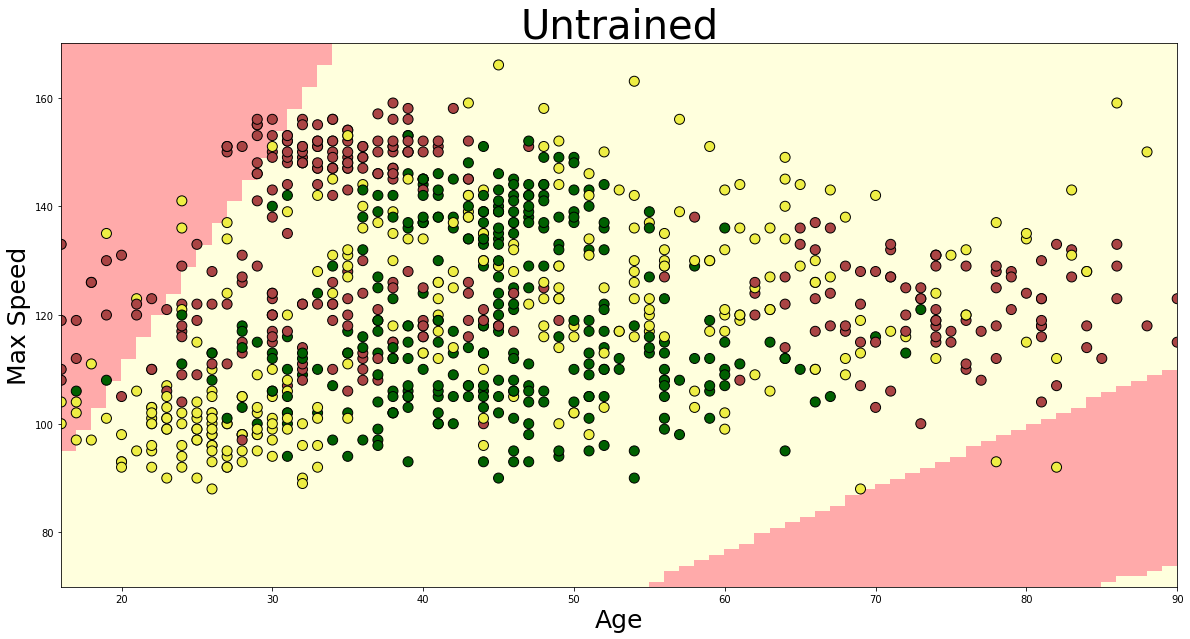

In [26]:
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Untrained")

In [35]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [36]:
# only if you are running this locally

# https://keras.io/callbacks/#tensorboard
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=./tf_log
# open http://localhost:6006

In [37]:
BATCH_SIZE=1000
EPOCHS = 5000

# only if you are running this locally
# !rm -rf ./tf_log
# %time model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])

%time history = model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/5000
720/720 [==============================] - 0s 367us/step - loss: 1.2830 - acc: 0.3361 - val_loss: 3.2288 - val_acc: 0.3333
Epoch 2/5000
720/720 [==============================] - 0s 11us/step - loss: 3.2499 - acc: 0.3333 - val_loss: 3.1032 - val_acc: 0.3389
Epoch 3/5000
720/720 [==============================] - 0s 11us/step - loss: 3.1373 - acc: 0.3306 - val_loss: 1.6909 - val_acc: 0.3389
Epoch 4/5000
720/720 [==============================] - 0s 11us/step - loss: 1.7015 - acc: 0.3306 - val_loss: 1.3846 - val_acc: 0.4000
Epoch 5/5000
720/720 [==============================] - 0s 11us/step - loss: 1.3453 - acc: 0.3986 - val_loss: 2.0795 - val_acc: 0.3278
Epoch 6/5000
720/720 [==============================] - 0s 11us/step - loss: 2.0133 - acc: 0.3361 - val_loss: 1.9023 - val_acc: 0.4556
Epoch 7/5000
720/720 [==============================] - 0s 11us/step - loss: 1.8413 - acc: 0.4861 - val_loss: 1.5678 - val_acc: 0.4778
Epoch 8/

Epoch 61/5000
720/720 [==============================] - 0s 11us/step - loss: 0.8732 - acc: 0.5917 - val_loss: 0.9739 - val_acc: 0.5833
Epoch 62/5000
720/720 [==============================] - 0s 11us/step - loss: 0.8717 - acc: 0.5958 - val_loss: 0.9715 - val_acc: 0.5611
Epoch 63/5000
720/720 [==============================] - 0s 11us/step - loss: 0.8699 - acc: 0.6028 - val_loss: 0.9700 - val_acc: 0.5722
Epoch 64/5000
720/720 [==============================] - 0s 11us/step - loss: 0.8696 - acc: 0.6042 - val_loss: 0.9687 - val_acc: 0.5500
Epoch 65/5000
720/720 [==============================] - 0s 11us/step - loss: 0.8698 - acc: 0.6028 - val_loss: 0.9666 - val_acc: 0.5667
Epoch 66/5000
720/720 [==============================] - 0s 11us/step - loss: 0.8686 - acc: 0.6069 - val_loss: 0.9651 - val_acc: 0.5778
Epoch 67/5000
720/720 [==============================] - 0s 11us/step - loss: 0.8671 - acc: 0.6028 - val_loss: 0.9653 - val_acc: 0.5667
Epoch 68/5000
720/720 [=========================

Epoch 122/5000
720/720 [==============================] - 0s 6us/step - loss: 0.8322 - acc: 0.6583 - val_loss: 0.9256 - val_acc: 0.6278
Epoch 123/5000
720/720 [==============================] - 0s 6us/step - loss: 0.8316 - acc: 0.6569 - val_loss: 0.9261 - val_acc: 0.6167
Epoch 124/5000
720/720 [==============================] - 0s 6us/step - loss: 0.8310 - acc: 0.6611 - val_loss: 0.9231 - val_acc: 0.6278
Epoch 125/5000
720/720 [==============================] - 0s 6us/step - loss: 0.8304 - acc: 0.6625 - val_loss: 0.9237 - val_acc: 0.6222
Epoch 126/5000
720/720 [==============================] - 0s 11us/step - loss: 0.8298 - acc: 0.6625 - val_loss: 0.9215 - val_acc: 0.6222
Epoch 127/5000
720/720 [==============================] - 0s 11us/step - loss: 0.8293 - acc: 0.6653 - val_loss: 0.9223 - val_acc: 0.6278
Epoch 128/5000
720/720 [==============================] - 0s 22us/step - loss: 0.8287 - acc: 0.6611 - val_loss: 0.9209 - val_acc: 0.6167
Epoch 129/5000
720/720 [=====================

Epoch 182/5000
720/720 [==============================] - 0s 6us/step - loss: 0.8025 - acc: 0.6639 - val_loss: 0.8864 - val_acc: 0.6444
Epoch 183/5000
720/720 [==============================] - 0s 11us/step - loss: 0.8021 - acc: 0.6639 - val_loss: 0.8876 - val_acc: 0.6556
Epoch 184/5000
720/720 [==============================] - 0s 6us/step - loss: 0.8020 - acc: 0.6764 - val_loss: 0.8852 - val_acc: 0.6389
Epoch 185/5000
720/720 [==============================] - 0s 6us/step - loss: 0.8021 - acc: 0.6625 - val_loss: 0.8882 - val_acc: 0.6500
Epoch 186/5000
720/720 [==============================] - 0s 6us/step - loss: 0.8021 - acc: 0.6806 - val_loss: 0.8845 - val_acc: 0.6333
Epoch 187/5000
720/720 [==============================] - 0s 6us/step - loss: 0.8023 - acc: 0.6611 - val_loss: 0.8886 - val_acc: 0.6389
Epoch 188/5000
720/720 [==============================] - 0s 6us/step - loss: 0.8023 - acc: 0.6722 - val_loss: 0.8840 - val_acc: 0.6333
Epoch 189/5000
720/720 [=======================

Epoch 242/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7879 - acc: 0.6681 - val_loss: 0.8708 - val_acc: 0.6333
Epoch 243/5000
720/720 [==============================] - 0s 6us/step - loss: 0.7942 - acc: 0.6556 - val_loss: 0.8872 - val_acc: 0.5889
Epoch 244/5000
720/720 [==============================] - 0s 6us/step - loss: 0.8052 - acc: 0.6375 - val_loss: 0.8910 - val_acc: 0.6278
Epoch 245/5000
720/720 [==============================] - 0s 6us/step - loss: 0.8166 - acc: 0.6528 - val_loss: 0.8928 - val_acc: 0.6000
Epoch 246/5000
720/720 [==============================] - 0s 11us/step - loss: 0.8096 - acc: 0.6403 - val_loss: 0.8669 - val_acc: 0.6333
Epoch 247/5000
720/720 [==============================] - 0s 22us/step - loss: 0.7891 - acc: 0.6583 - val_loss: 0.8612 - val_acc: 0.6444
Epoch 248/5000
720/720 [==============================] - 0s 17us/step - loss: 0.7821 - acc: 0.6667 - val_loss: 0.8762 - val_acc: 0.5889
Epoch 249/5000
720/720 [====================

Epoch 302/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7784 - acc: 0.6639 - val_loss: 0.8543 - val_acc: 0.6611
Epoch 303/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7746 - acc: 0.6653 - val_loss: 0.8516 - val_acc: 0.6444
Epoch 304/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7713 - acc: 0.6806 - val_loss: 0.8502 - val_acc: 0.6556
Epoch 305/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7701 - acc: 0.6792 - val_loss: 0.8510 - val_acc: 0.6611
Epoch 306/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7709 - acc: 0.6750 - val_loss: 0.8531 - val_acc: 0.6333
Epoch 307/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7727 - acc: 0.6778 - val_loss: 0.8543 - val_acc: 0.6556
Epoch 308/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7742 - acc: 0.6639 - val_loss: 0.8545 - val_acc: 0.6167
Epoch 309/5000
720/720 [=================

Epoch 362/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7636 - acc: 0.6819 - val_loss: 0.8439 - val_acc: 0.6444
Epoch 363/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7622 - acc: 0.6764 - val_loss: 0.8430 - val_acc: 0.6444
Epoch 364/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7620 - acc: 0.6764 - val_loss: 0.8428 - val_acc: 0.6389
Epoch 365/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7627 - acc: 0.6806 - val_loss: 0.8445 - val_acc: 0.6556
Epoch 366/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7635 - acc: 0.6792 - val_loss: 0.8440 - val_acc: 0.6333
Epoch 367/5000
720/720 [==============================] - 0s 17us/step - loss: 0.7636 - acc: 0.6819 - val_loss: 0.8448 - val_acc: 0.6500
Epoch 368/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7630 - acc: 0.6778 - val_loss: 0.8433 - val_acc: 0.6444
Epoch 369/5000
720/720 [=================

Epoch 422/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7575 - acc: 0.6806 - val_loss: 0.8408 - val_acc: 0.6500
Epoch 423/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7565 - acc: 0.6792 - val_loss: 0.8390 - val_acc: 0.6444
Epoch 424/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7554 - acc: 0.6833 - val_loss: 0.8393 - val_acc: 0.6389
Epoch 425/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7552 - acc: 0.6792 - val_loss: 0.8406 - val_acc: 0.6500
Epoch 426/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7558 - acc: 0.6778 - val_loss: 0.8393 - val_acc: 0.6333
Epoch 427/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7562 - acc: 0.6806 - val_loss: 0.8403 - val_acc: 0.6500
Epoch 428/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7558 - acc: 0.6778 - val_loss: 0.8384 - val_acc: 0.6444
Epoch 429/5000
720/720 [=================

Epoch 482/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7527 - acc: 0.6750 - val_loss: 0.8409 - val_acc: 0.6444
Epoch 483/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7530 - acc: 0.6806 - val_loss: 0.8373 - val_acc: 0.6278
Epoch 484/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7513 - acc: 0.6792 - val_loss: 0.8367 - val_acc: 0.6444
Epoch 485/5000
720/720 [==============================] - 0s 22us/step - loss: 0.7496 - acc: 0.6778 - val_loss: 0.8360 - val_acc: 0.6556
Epoch 486/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7498 - acc: 0.6806 - val_loss: 0.8352 - val_acc: 0.6333
Epoch 487/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7510 - acc: 0.6806 - val_loss: 0.8391 - val_acc: 0.6444
Epoch 488/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7515 - acc: 0.6819 - val_loss: 0.8369 - val_acc: 0.6278
Epoch 489/5000
720/720 [=================

Epoch 542/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7623 - acc: 0.6750 - val_loss: 0.8386 - val_acc: 0.6444
Epoch 543/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7462 - acc: 0.6819 - val_loss: 0.8435 - val_acc: 0.6167
Epoch 544/5000
720/720 [==============================] - 0s 6us/step - loss: 0.7538 - acc: 0.6708 - val_loss: 0.8592 - val_acc: 0.6444
Epoch 545/5000
720/720 [==============================] - 0s 6us/step - loss: 0.7626 - acc: 0.6736 - val_loss: 0.8440 - val_acc: 0.6222
Epoch 546/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7522 - acc: 0.6722 - val_loss: 0.8398 - val_acc: 0.6333
Epoch 547/5000
720/720 [==============================] - 0s 6us/step - loss: 0.7459 - acc: 0.6819 - val_loss: 0.8506 - val_acc: 0.6556
Epoch 548/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7542 - acc: 0.6792 - val_loss: 0.8442 - val_acc: 0.6167
Epoch 549/5000
720/720 [====================

Epoch 602/5000
720/720 [==============================] - 0s 22us/step - loss: 0.7397 - acc: 0.6847 - val_loss: 0.8317 - val_acc: 0.6500
Epoch 603/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7396 - acc: 0.6861 - val_loss: 0.8315 - val_acc: 0.6444
Epoch 604/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7395 - acc: 0.6833 - val_loss: 0.8318 - val_acc: 0.6500
Epoch 605/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7394 - acc: 0.6861 - val_loss: 0.8316 - val_acc: 0.6444
Epoch 606/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7393 - acc: 0.6847 - val_loss: 0.8316 - val_acc: 0.6500
Epoch 607/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7393 - acc: 0.6861 - val_loss: 0.8313 - val_acc: 0.6444
Epoch 608/5000
720/720 [==============================] - 0s 6us/step - loss: 0.7392 - acc: 0.6847 - val_loss: 0.8315 - val_acc: 0.6500
Epoch 609/5000
720/720 [==================

Epoch 662/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7364 - acc: 0.6861 - val_loss: 0.8305 - val_acc: 0.6500
Epoch 663/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7354 - acc: 0.6889 - val_loss: 0.8302 - val_acc: 0.6500
Epoch 664/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7348 - acc: 0.6875 - val_loss: 0.8282 - val_acc: 0.6389
Epoch 665/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7351 - acc: 0.6875 - val_loss: 0.8309 - val_acc: 0.6500
Epoch 666/5000
720/720 [==============================] - 0s 22us/step - loss: 0.7355 - acc: 0.6889 - val_loss: 0.8296 - val_acc: 0.6389
Epoch 667/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7354 - acc: 0.6931 - val_loss: 0.8302 - val_acc: 0.6556
Epoch 668/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7349 - acc: 0.6889 - val_loss: 0.8303 - val_acc: 0.6500
Epoch 669/5000
720/720 [=================

Epoch 722/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7386 - acc: 0.6778 - val_loss: 0.8268 - val_acc: 0.6444
Epoch 723/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7315 - acc: 0.6861 - val_loss: 0.8398 - val_acc: 0.6500
Epoch 724/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7396 - acc: 0.6944 - val_loss: 0.8466 - val_acc: 0.6444
Epoch 725/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7437 - acc: 0.6694 - val_loss: 0.8365 - val_acc: 0.6278
Epoch 726/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7375 - acc: 0.6792 - val_loss: 0.8295 - val_acc: 0.6500
Epoch 727/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7308 - acc: 0.6931 - val_loss: 0.8316 - val_acc: 0.6611
Epoch 728/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7360 - acc: 0.6806 - val_loss: 0.8386 - val_acc: 0.6444
Epoch 729/5000
720/720 [=================

Epoch 782/5000
720/720 [==============================] - 0s 6us/step - loss: 0.7247 - acc: 0.6931 - val_loss: 0.8229 - val_acc: 0.6500
Epoch 783/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7246 - acc: 0.6944 - val_loss: 0.8228 - val_acc: 0.6500
Epoch 784/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7245 - acc: 0.6944 - val_loss: 0.8225 - val_acc: 0.6500
Epoch 785/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7244 - acc: 0.6931 - val_loss: 0.8227 - val_acc: 0.6500
Epoch 786/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7243 - acc: 0.6944 - val_loss: 0.8222 - val_acc: 0.6444
Epoch 787/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7242 - acc: 0.6931 - val_loss: 0.8227 - val_acc: 0.6500
Epoch 788/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7241 - acc: 0.6944 - val_loss: 0.8223 - val_acc: 0.6500
Epoch 789/5000
720/720 [==================

Epoch 842/5000
720/720 [==============================] - 0s 6us/step - loss: 0.7206 - acc: 0.6917 - val_loss: 0.8190 - val_acc: 0.6389
Epoch 843/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7209 - acc: 0.6958 - val_loss: 0.8214 - val_acc: 0.6444
Epoch 844/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7198 - acc: 0.6972 - val_loss: 0.8213 - val_acc: 0.6500
Epoch 845/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7196 - acc: 0.6944 - val_loss: 0.8180 - val_acc: 0.6444
Epoch 846/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7202 - acc: 0.6958 - val_loss: 0.8223 - val_acc: 0.6556
Epoch 847/5000
720/720 [==============================] - 0s 22us/step - loss: 0.7199 - acc: 0.6986 - val_loss: 0.8191 - val_acc: 0.6444
Epoch 848/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7191 - acc: 0.6958 - val_loss: 0.8194 - val_acc: 0.6500
Epoch 849/5000
720/720 [==================

Epoch 902/5000
720/720 [==============================] - 0s 6us/step - loss: 0.7150 - acc: 0.6972 - val_loss: 0.8172 - val_acc: 0.6500
Epoch 903/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7144 - acc: 0.6931 - val_loss: 0.8132 - val_acc: 0.6444
Epoch 904/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7137 - acc: 0.7028 - val_loss: 0.8142 - val_acc: 0.6444
Epoch 905/5000
720/720 [==============================] - 0s 28us/step - loss: 0.7133 - acc: 0.6972 - val_loss: 0.8159 - val_acc: 0.6500
Epoch 906/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7133 - acc: 0.6944 - val_loss: 0.8145 - val_acc: 0.6444
Epoch 907/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7135 - acc: 0.7014 - val_loss: 0.8172 - val_acc: 0.6500
Epoch 908/5000
720/720 [==============================] - 0s 6us/step - loss: 0.7136 - acc: 0.6958 - val_loss: 0.8140 - val_acc: 0.6500
Epoch 909/5000
720/720 [===================

Epoch 962/5000
720/720 [==============================] - 0s 6us/step - loss: 0.7080 - acc: 0.7056 - val_loss: 0.8071 - val_acc: 0.6500
Epoch 963/5000
720/720 [==============================] - 0s 6us/step - loss: 0.7083 - acc: 0.6972 - val_loss: 0.8134 - val_acc: 0.6667
Epoch 964/5000
720/720 [==============================] - 0s 6us/step - loss: 0.7093 - acc: 0.7056 - val_loss: 0.8085 - val_acc: 0.6444
Epoch 965/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7108 - acc: 0.6903 - val_loss: 0.8192 - val_acc: 0.6722
Epoch 966/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7134 - acc: 0.7097 - val_loss: 0.8115 - val_acc: 0.6333
Epoch 967/5000
720/720 [==============================] - 0s 28us/step - loss: 0.7157 - acc: 0.6903 - val_loss: 0.8282 - val_acc: 0.6722
Epoch 968/5000
720/720 [==============================] - 0s 11us/step - loss: 0.7199 - acc: 0.7056 - val_loss: 0.8141 - val_acc: 0.6278
Epoch 969/5000
720/720 [====================

Epoch 1022/5000
720/720 [==============================] - 0s 22us/step - loss: 0.7095 - acc: 0.6958 - val_loss: 0.8100 - val_acc: 0.6500
Epoch 1023/5000
720/720 [==============================] - 0s 22us/step - loss: 0.7037 - acc: 0.6944 - val_loss: 0.8051 - val_acc: 0.6667
Epoch 1024/5000
720/720 [==============================] - 0s 22us/step - loss: 0.7004 - acc: 0.7056 - val_loss: 0.8032 - val_acc: 0.6500
Epoch 1025/5000
720/720 [==============================] - 0s 22us/step - loss: 0.7005 - acc: 0.7028 - val_loss: 0.8110 - val_acc: 0.6611
Epoch 1026/5000
720/720 [==============================] - 0s 17us/step - loss: 0.7030 - acc: 0.7042 - val_loss: 0.8040 - val_acc: 0.6500
Epoch 1027/5000
720/720 [==============================] - 0s 17us/step - loss: 0.7049 - acc: 0.7000 - val_loss: 0.8110 - val_acc: 0.6556
Epoch 1028/5000
720/720 [==============================] - 0s 17us/step - loss: 0.7047 - acc: 0.6972 - val_loss: 0.8017 - val_acc: 0.6611
Epoch 1029/5000
720/720 [=========

Epoch 1082/5000
720/720 [==============================] - 0s 0us/step - loss: 0.6941 - acc: 0.7028 - val_loss: 0.7952 - val_acc: 0.6611
Epoch 1083/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6937 - acc: 0.7139 - val_loss: 0.7983 - val_acc: 0.6556
Epoch 1084/5000
720/720 [==============================] - 0s 0us/step - loss: 0.6934 - acc: 0.7056 - val_loss: 0.7942 - val_acc: 0.6500
Epoch 1085/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6934 - acc: 0.7139 - val_loss: 0.7996 - val_acc: 0.6611
Epoch 1086/5000
720/720 [==============================] - 0s 0us/step - loss: 0.6938 - acc: 0.7083 - val_loss: 0.7945 - val_acc: 0.6556
Epoch 1087/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6944 - acc: 0.7097 - val_loss: 0.8036 - val_acc: 0.6611
Epoch 1088/5000
720/720 [==============================] - 0s 0us/step - loss: 0.6960 - acc: 0.7069 - val_loss: 0.7962 - val_acc: 0.6444
Epoch 1089/5000
720/720 [=============

Epoch 1142/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6908 - acc: 0.7000 - val_loss: 0.7917 - val_acc: 0.6778
Epoch 1143/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6901 - acc: 0.7125 - val_loss: 0.7958 - val_acc: 0.6667
Epoch 1144/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6880 - acc: 0.7056 - val_loss: 0.7904 - val_acc: 0.6722
Epoch 1145/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6872 - acc: 0.7153 - val_loss: 0.7942 - val_acc: 0.6667
Epoch 1146/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6879 - acc: 0.7097 - val_loss: 0.7931 - val_acc: 0.6556
Epoch 1147/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6880 - acc: 0.7028 - val_loss: 0.7917 - val_acc: 0.6833
Epoch 1148/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6874 - acc: 0.7181 - val_loss: 0.7962 - val_acc: 0.6722
Epoch 1149/5000
720/720 [===========

Epoch 1202/5000
720/720 [==============================] - 0s 0us/step - loss: 0.6910 - acc: 0.7111 - val_loss: 0.7973 - val_acc: 0.6611
Epoch 1203/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6825 - acc: 0.7125 - val_loss: 0.7919 - val_acc: 0.6778
Epoch 1204/5000
720/720 [==============================] - 0s 0us/step - loss: 0.6794 - acc: 0.7194 - val_loss: 0.7904 - val_acc: 0.6722
Epoch 1205/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6822 - acc: 0.7181 - val_loss: 0.8007 - val_acc: 0.6611
Epoch 1206/5000
720/720 [==============================] - 0s 9us/step - loss: 0.6865 - acc: 0.7042 - val_loss: 0.7930 - val_acc: 0.6778
Epoch 1207/5000
720/720 [==============================] - 0s 0us/step - loss: 0.6895 - acc: 0.7139 - val_loss: 0.7981 - val_acc: 0.6611
Epoch 1208/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6862 - acc: 0.7028 - val_loss: 0.7893 - val_acc: 0.6722
Epoch 1209/5000
720/720 [=============

Epoch 1262/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6788 - acc: 0.7069 - val_loss: 0.7867 - val_acc: 0.6778
Epoch 1263/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6746 - acc: 0.7278 - val_loss: 0.7968 - val_acc: 0.6833
Epoch 1264/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6807 - acc: 0.7153 - val_loss: 0.7883 - val_acc: 0.6500
Epoch 1265/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6835 - acc: 0.7069 - val_loss: 0.7915 - val_acc: 0.6778
Epoch 1266/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6786 - acc: 0.7097 - val_loss: 0.7850 - val_acc: 0.6778
Epoch 1267/5000
720/720 [==============================] - 0s 28us/step - loss: 0.6734 - acc: 0.7250 - val_loss: 0.7867 - val_acc: 0.6611
Epoch 1268/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6757 - acc: 0.7181 - val_loss: 0.7958 - val_acc: 0.6778
Epoch 1269/5000
720/720 [==========

Epoch 1322/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6687 - acc: 0.7236 - val_loss: 0.7892 - val_acc: 0.6556
Epoch 1323/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6707 - acc: 0.7125 - val_loss: 0.7843 - val_acc: 0.6667
Epoch 1324/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6716 - acc: 0.7153 - val_loss: 0.7867 - val_acc: 0.6611
Epoch 1325/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6694 - acc: 0.7181 - val_loss: 0.7826 - val_acc: 0.6778
Epoch 1326/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6673 - acc: 0.7250 - val_loss: 0.7823 - val_acc: 0.6778
Epoch 1327/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6668 - acc: 0.7236 - val_loss: 0.7851 - val_acc: 0.6722
Epoch 1328/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6679 - acc: 0.7139 - val_loss: 0.7821 - val_acc: 0.6722
Epoch 1329/5000
720/720 [=========

Epoch 1382/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6613 - acc: 0.7222 - val_loss: 0.7853 - val_acc: 0.6722
Epoch 1383/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6623 - acc: 0.7181 - val_loss: 0.7811 - val_acc: 0.6722
Epoch 1384/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6654 - acc: 0.7194 - val_loss: 0.7918 - val_acc: 0.6667
Epoch 1385/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6676 - acc: 0.7153 - val_loss: 0.7827 - val_acc: 0.6722
Epoch 1386/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6690 - acc: 0.7208 - val_loss: 0.7904 - val_acc: 0.6667
Epoch 1387/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6664 - acc: 0.7139 - val_loss: 0.7818 - val_acc: 0.6667
Epoch 1388/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6637 - acc: 0.7222 - val_loss: 0.7835 - val_acc: 0.6722
Epoch 1389/5000
720/720 [==========

Epoch 1442/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6557 - acc: 0.7250 - val_loss: 0.7782 - val_acc: 0.6722
Epoch 1443/5000
720/720 [==============================] - 0s 17us/step - loss: 0.6555 - acc: 0.7278 - val_loss: 0.7783 - val_acc: 0.6722
Epoch 1444/5000
720/720 [==============================] - 0s 17us/step - loss: 0.6554 - acc: 0.7264 - val_loss: 0.7793 - val_acc: 0.6778
Epoch 1445/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6555 - acc: 0.7236 - val_loss: 0.7773 - val_acc: 0.6722
Epoch 1446/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6556 - acc: 0.7264 - val_loss: 0.7806 - val_acc: 0.6778
Epoch 1447/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6558 - acc: 0.7208 - val_loss: 0.7768 - val_acc: 0.6722
Epoch 1448/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6562 - acc: 0.7236 - val_loss: 0.7822 - val_acc: 0.6722
Epoch 1449/5000
720/720 [=========

Epoch 1502/5000
720/720 [==============================] - 0s 17us/step - loss: 0.6544 - acc: 0.7222 - val_loss: 0.7859 - val_acc: 0.6667
Epoch 1503/5000
720/720 [==============================] - 0s 17us/step - loss: 0.6562 - acc: 0.7194 - val_loss: 0.7780 - val_acc: 0.6667
Epoch 1504/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6607 - acc: 0.7194 - val_loss: 0.7972 - val_acc: 0.6722
Epoch 1505/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6645 - acc: 0.7083 - val_loss: 0.7853 - val_acc: 0.6667
Epoch 1506/5000
720/720 [==============================] - 0s 28us/step - loss: 0.6732 - acc: 0.7097 - val_loss: 0.8084 - val_acc: 0.6667
Epoch 1507/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6730 - acc: 0.7083 - val_loss: 0.7876 - val_acc: 0.6667
Epoch 1508/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6741 - acc: 0.7097 - val_loss: 0.7986 - val_acc: 0.6667
Epoch 1509/5000
720/720 [=========

Epoch 1562/5000
720/720 [==============================] - 0s 17us/step - loss: 0.6596 - acc: 0.7236 - val_loss: 0.7780 - val_acc: 0.6667
Epoch 1563/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6534 - acc: 0.7208 - val_loss: 0.7827 - val_acc: 0.6667
Epoch 1564/5000
720/720 [==============================] - 0s 17us/step - loss: 0.6474 - acc: 0.7250 - val_loss: 0.7737 - val_acc: 0.6722
Epoch 1565/5000
720/720 [==============================] - 0s 28us/step - loss: 0.6457 - acc: 0.7347 - val_loss: 0.7776 - val_acc: 0.6667
Epoch 1566/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6477 - acc: 0.7236 - val_loss: 0.7828 - val_acc: 0.6722
Epoch 1567/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6507 - acc: 0.7222 - val_loss: 0.7795 - val_acc: 0.6667
Epoch 1568/5000
720/720 [==============================] - 0s 17us/step - loss: 0.6540 - acc: 0.7222 - val_loss: 0.7886 - val_acc: 0.6667
Epoch 1569/5000
720/720 [=========

Epoch 1622/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6580 - acc: 0.7236 - val_loss: 0.7818 - val_acc: 0.6778
Epoch 1623/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6558 - acc: 0.7167 - val_loss: 0.7878 - val_acc: 0.6667
Epoch 1624/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6473 - acc: 0.7222 - val_loss: 0.7750 - val_acc: 0.6722
Epoch 1625/5000
720/720 [==============================] - 0s 17us/step - loss: 0.6417 - acc: 0.7361 - val_loss: 0.7757 - val_acc: 0.6667
Epoch 1626/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6395 - acc: 0.7333 - val_loss: 0.7792 - val_acc: 0.6611
Epoch 1627/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6412 - acc: 0.7292 - val_loss: 0.7752 - val_acc: 0.6722
Epoch 1628/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6451 - acc: 0.7264 - val_loss: 0.7867 - val_acc: 0.6722
Epoch 1629/5000
720/720 [=============

Epoch 1682/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6468 - acc: 0.7222 - val_loss: 0.7769 - val_acc: 0.6778
Epoch 1683/5000
720/720 [==============================] - 0s 28us/step - loss: 0.6462 - acc: 0.7208 - val_loss: 0.7855 - val_acc: 0.6722
Epoch 1684/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6419 - acc: 0.7264 - val_loss: 0.7733 - val_acc: 0.6722
Epoch 1685/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6386 - acc: 0.7333 - val_loss: 0.7776 - val_acc: 0.6611
Epoch 1686/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6356 - acc: 0.7306 - val_loss: 0.7734 - val_acc: 0.6667
Epoch 1687/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6344 - acc: 0.7347 - val_loss: 0.7733 - val_acc: 0.6722
Epoch 1688/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6348 - acc: 0.7375 - val_loss: 0.7777 - val_acc: 0.6556
Epoch 1689/5000
720/720 [=========

Epoch 1742/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6370 - acc: 0.7319 - val_loss: 0.7830 - val_acc: 0.6722
Epoch 1743/5000
720/720 [==============================] - 0s 17us/step - loss: 0.6471 - acc: 0.7264 - val_loss: 0.7925 - val_acc: 0.6722
Epoch 1744/5000
720/720 [==============================] - 0s 17us/step - loss: 0.6447 - acc: 0.7194 - val_loss: 0.7795 - val_acc: 0.6722
Epoch 1745/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6389 - acc: 0.7264 - val_loss: 0.7770 - val_acc: 0.6611
Epoch 1746/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6312 - acc: 0.7375 - val_loss: 0.7745 - val_acc: 0.6611
Epoch 1747/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6306 - acc: 0.7375 - val_loss: 0.7764 - val_acc: 0.6778
Epoch 1748/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6356 - acc: 0.7264 - val_loss: 0.7854 - val_acc: 0.6722
Epoch 1749/5000
720/720 [==========

Epoch 1802/5000
720/720 [==============================] - 0s 17us/step - loss: 0.6268 - acc: 0.7347 - val_loss: 0.7685 - val_acc: 0.6778
Epoch 1803/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6280 - acc: 0.7375 - val_loss: 0.7821 - val_acc: 0.6667
Epoch 1804/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6300 - acc: 0.7306 - val_loss: 0.7697 - val_acc: 0.6722
Epoch 1805/5000
720/720 [==============================] - 0s 17us/step - loss: 0.6335 - acc: 0.7306 - val_loss: 0.7926 - val_acc: 0.6611
Epoch 1806/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6383 - acc: 0.7278 - val_loss: 0.7772 - val_acc: 0.6889
Epoch 1807/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6464 - acc: 0.7194 - val_loss: 0.8072 - val_acc: 0.6722
Epoch 1808/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6508 - acc: 0.7222 - val_loss: 0.7862 - val_acc: 0.6833
Epoch 1809/5000
720/720 [=========

Epoch 1862/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6205 - acc: 0.7333 - val_loss: 0.7684 - val_acc: 0.6778
Epoch 1863/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6205 - acc: 0.7347 - val_loss: 0.7715 - val_acc: 0.6722
Epoch 1864/5000
720/720 [==============================] - 0s 17us/step - loss: 0.6206 - acc: 0.7389 - val_loss: 0.7679 - val_acc: 0.6778
Epoch 1865/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6208 - acc: 0.7375 - val_loss: 0.7729 - val_acc: 0.6722
Epoch 1866/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6211 - acc: 0.7403 - val_loss: 0.7685 - val_acc: 0.6889
Epoch 1867/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6219 - acc: 0.7361 - val_loss: 0.7756 - val_acc: 0.6722
Epoch 1868/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6232 - acc: 0.7417 - val_loss: 0.7706 - val_acc: 0.6778
Epoch 1869/5000
720/720 [=========

Epoch 1922/5000
720/720 [==============================] - 0s 17us/step - loss: 0.6163 - acc: 0.7347 - val_loss: 0.7707 - val_acc: 0.6722
Epoch 1923/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6161 - acc: 0.7375 - val_loss: 0.7679 - val_acc: 0.6833
Epoch 1924/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6161 - acc: 0.7347 - val_loss: 0.7705 - val_acc: 0.6722
Epoch 1925/5000
720/720 [==============================] - 0s 33us/step - loss: 0.6160 - acc: 0.7375 - val_loss: 0.7679 - val_acc: 0.6833
Epoch 1926/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6159 - acc: 0.7333 - val_loss: 0.7706 - val_acc: 0.6722
Epoch 1927/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6159 - acc: 0.7361 - val_loss: 0.7678 - val_acc: 0.6889
Epoch 1928/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6160 - acc: 0.7347 - val_loss: 0.7709 - val_acc: 0.6722
Epoch 1929/5000
720/720 [==========

Epoch 1982/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6188 - acc: 0.7264 - val_loss: 0.7704 - val_acc: 0.6778
Epoch 1983/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6215 - acc: 0.7333 - val_loss: 0.7834 - val_acc: 0.6722
Epoch 1984/5000
720/720 [==============================] - 0s 33us/step - loss: 0.6213 - acc: 0.7264 - val_loss: 0.7720 - val_acc: 0.6778
Epoch 1985/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6229 - acc: 0.7333 - val_loss: 0.7827 - val_acc: 0.6722
Epoch 1986/5000
720/720 [==============================] - 0s 28us/step - loss: 0.6202 - acc: 0.7264 - val_loss: 0.7704 - val_acc: 0.6778
Epoch 1987/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6189 - acc: 0.7375 - val_loss: 0.7768 - val_acc: 0.6722
Epoch 1988/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6154 - acc: 0.7389 - val_loss: 0.7680 - val_acc: 0.6833
Epoch 1989/5000
720/720 [=========

Epoch 2042/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6178 - acc: 0.7375 - val_loss: 0.7870 - val_acc: 0.6722
Epoch 2043/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6187 - acc: 0.7250 - val_loss: 0.7699 - val_acc: 0.6778
Epoch 2044/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6209 - acc: 0.7292 - val_loss: 0.7863 - val_acc: 0.6778
Epoch 2045/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6181 - acc: 0.7250 - val_loss: 0.7707 - val_acc: 0.6778
Epoch 2046/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6168 - acc: 0.7333 - val_loss: 0.7784 - val_acc: 0.6722
Epoch 2047/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6123 - acc: 0.7347 - val_loss: 0.7708 - val_acc: 0.6889
Epoch 2048/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6099 - acc: 0.7375 - val_loss: 0.7695 - val_acc: 0.6722
Epoch 2049/5000
720/720 [============

Epoch 2102/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6111 - acc: 0.7292 - val_loss: 0.7696 - val_acc: 0.6778
Epoch 2103/5000
720/720 [==============================] - 0s 6us/step - loss: 0.6195 - acc: 0.7278 - val_loss: 0.7966 - val_acc: 0.6722
Epoch 2104/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6247 - acc: 0.7264 - val_loss: 0.7820 - val_acc: 0.6833
Epoch 2105/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6369 - acc: 0.7208 - val_loss: 0.8026 - val_acc: 0.6778
Epoch 2106/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6284 - acc: 0.7236 - val_loss: 0.7743 - val_acc: 0.6778
Epoch 2107/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6222 - acc: 0.7306 - val_loss: 0.7810 - val_acc: 0.6722
Epoch 2108/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6082 - acc: 0.7347 - val_loss: 0.7662 - val_acc: 0.6722
Epoch 2109/5000
720/720 [===========

Epoch 2162/5000
720/720 [==============================] - 0s 28us/step - loss: 0.6093 - acc: 0.7361 - val_loss: 0.7857 - val_acc: 0.6778
Epoch 2163/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6091 - acc: 0.7250 - val_loss: 0.7647 - val_acc: 0.6889
Epoch 2164/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6092 - acc: 0.7361 - val_loss: 0.7824 - val_acc: 0.6722
Epoch 2165/5000
720/720 [==============================] - 0s 11us/step - loss: 0.6058 - acc: 0.7306 - val_loss: 0.7632 - val_acc: 0.6778
Epoch 2166/5000
720/720 [==============================] - 0s 22us/step - loss: 0.6027 - acc: 0.7361 - val_loss: 0.7729 - val_acc: 0.6722
Epoch 2167/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5991 - acc: 0.7444 - val_loss: 0.7638 - val_acc: 0.6778
Epoch 2168/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5970 - acc: 0.7403 - val_loss: 0.7645 - val_acc: 0.6778
Epoch 2169/5000
720/720 [=========

Epoch 2222/5000
720/720 [==============================] - 0s 28us/step - loss: 0.5929 - acc: 0.7458 - val_loss: 0.7634 - val_acc: 0.6722
Epoch 2223/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5922 - acc: 0.7375 - val_loss: 0.7600 - val_acc: 0.6722
Epoch 2224/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5922 - acc: 0.7444 - val_loss: 0.7644 - val_acc: 0.6778
Epoch 2225/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5928 - acc: 0.7417 - val_loss: 0.7597 - val_acc: 0.6778
Epoch 2226/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5941 - acc: 0.7431 - val_loss: 0.7681 - val_acc: 0.6667
Epoch 2227/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5953 - acc: 0.7375 - val_loss: 0.7603 - val_acc: 0.6778
Epoch 2228/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5972 - acc: 0.7431 - val_loss: 0.7733 - val_acc: 0.6667
Epoch 2229/5000
720/720 [=========

Epoch 2282/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5872 - acc: 0.7458 - val_loss: 0.7622 - val_acc: 0.6722
Epoch 2283/5000
720/720 [==============================] - 0s 44us/step - loss: 0.5875 - acc: 0.7417 - val_loss: 0.7572 - val_acc: 0.6722
Epoch 2284/5000
720/720 [==============================] - 0s 28us/step - loss: 0.5884 - acc: 0.7458 - val_loss: 0.7667 - val_acc: 0.6722
Epoch 2285/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5896 - acc: 0.7375 - val_loss: 0.7568 - val_acc: 0.6722
Epoch 2286/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5915 - acc: 0.7417 - val_loss: 0.7725 - val_acc: 0.6667
Epoch 2287/5000
720/720 [==============================] - 0s 17us/step - loss: 0.5930 - acc: 0.7347 - val_loss: 0.7583 - val_acc: 0.6722
Epoch 2288/5000
720/720 [==============================] - 0s 17us/step - loss: 0.5953 - acc: 0.7431 - val_loss: 0.7773 - val_acc: 0.6667
Epoch 2289/5000
720/720 [=========

Epoch 2342/5000
720/720 [==============================] - 0s 33us/step - loss: 0.5835 - acc: 0.7375 - val_loss: 0.7586 - val_acc: 0.6778
Epoch 2343/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5835 - acc: 0.7472 - val_loss: 0.7610 - val_acc: 0.6667
Epoch 2344/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5833 - acc: 0.7389 - val_loss: 0.7601 - val_acc: 0.6722
Epoch 2345/5000
720/720 [==============================] - 0s 28us/step - loss: 0.5830 - acc: 0.7458 - val_loss: 0.7586 - val_acc: 0.6667
Epoch 2346/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5827 - acc: 0.7431 - val_loss: 0.7621 - val_acc: 0.6722
Epoch 2347/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5827 - acc: 0.7403 - val_loss: 0.7562 - val_acc: 0.6722
Epoch 2348/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5831 - acc: 0.7431 - val_loss: 0.7655 - val_acc: 0.6778
Epoch 2349/5000
720/720 [==========

Epoch 2402/5000
720/720 [==============================] - 0s 28us/step - loss: 0.5785 - acc: 0.7389 - val_loss: 0.7580 - val_acc: 0.6833
Epoch 2403/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5786 - acc: 0.7444 - val_loss: 0.7636 - val_acc: 0.6722
Epoch 2404/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5789 - acc: 0.7403 - val_loss: 0.7554 - val_acc: 0.6944
Epoch 2405/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5793 - acc: 0.7472 - val_loss: 0.7656 - val_acc: 0.6778
Epoch 2406/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5797 - acc: 0.7375 - val_loss: 0.7547 - val_acc: 0.6833
Epoch 2407/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5800 - acc: 0.7472 - val_loss: 0.7671 - val_acc: 0.6778
Epoch 2408/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5803 - acc: 0.7389 - val_loss: 0.7559 - val_acc: 0.6722
Epoch 2409/5000
720/720 [=========

Epoch 2462/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5771 - acc: 0.7361 - val_loss: 0.7602 - val_acc: 0.6722
Epoch 2463/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5740 - acc: 0.7458 - val_loss: 0.7600 - val_acc: 0.6833
Epoch 2464/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5740 - acc: 0.7514 - val_loss: 0.7707 - val_acc: 0.6722
Epoch 2465/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5762 - acc: 0.7444 - val_loss: 0.7571 - val_acc: 0.6944
Epoch 2466/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5790 - acc: 0.7486 - val_loss: 0.7770 - val_acc: 0.6667
Epoch 2467/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5807 - acc: 0.7375 - val_loss: 0.7571 - val_acc: 0.6889
Epoch 2468/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5814 - acc: 0.7444 - val_loss: 0.7753 - val_acc: 0.6667
Epoch 2469/5000
720/720 [==========

Epoch 2522/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5804 - acc: 0.7431 - val_loss: 0.7775 - val_acc: 0.6667
Epoch 2523/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5777 - acc: 0.7375 - val_loss: 0.7586 - val_acc: 0.6667
Epoch 2524/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5760 - acc: 0.7458 - val_loss: 0.7710 - val_acc: 0.6667
Epoch 2525/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5730 - acc: 0.7431 - val_loss: 0.7571 - val_acc: 0.6778
Epoch 2526/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5710 - acc: 0.7472 - val_loss: 0.7649 - val_acc: 0.6778
Epoch 2527/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5696 - acc: 0.7472 - val_loss: 0.7589 - val_acc: 0.6889
Epoch 2528/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5689 - acc: 0.7486 - val_loss: 0.7612 - val_acc: 0.6778
Epoch 2529/5000
720/720 [=========

Epoch 2582/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5714 - acc: 0.7431 - val_loss: 0.7784 - val_acc: 0.6667
Epoch 2583/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5724 - acc: 0.7500 - val_loss: 0.7608 - val_acc: 0.6833
Epoch 2584/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5746 - acc: 0.7417 - val_loss: 0.7813 - val_acc: 0.6722
Epoch 2585/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5743 - acc: 0.7486 - val_loss: 0.7606 - val_acc: 0.6889
Epoch 2586/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5752 - acc: 0.7431 - val_loss: 0.7801 - val_acc: 0.6722
Epoch 2587/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5729 - acc: 0.7444 - val_loss: 0.7592 - val_acc: 0.6944
Epoch 2588/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5715 - acc: 0.7444 - val_loss: 0.7749 - val_acc: 0.6667
Epoch 2589/5000
720/720 [=============

Epoch 2642/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5697 - acc: 0.7528 - val_loss: 0.7880 - val_acc: 0.6778
Epoch 2643/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5694 - acc: 0.7403 - val_loss: 0.7642 - val_acc: 0.6889
Epoch 2644/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5685 - acc: 0.7500 - val_loss: 0.7820 - val_acc: 0.6667
Epoch 2645/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5662 - acc: 0.7514 - val_loss: 0.7669 - val_acc: 0.6722
Epoch 2646/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5656 - acc: 0.7431 - val_loss: 0.7740 - val_acc: 0.6889
Epoch 2647/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5652 - acc: 0.7583 - val_loss: 0.7713 - val_acc: 0.6611
Epoch 2648/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5664 - acc: 0.7389 - val_loss: 0.7688 - val_acc: 0.6944
Epoch 2649/5000
720/720 [==========

Epoch 2702/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5569 - acc: 0.7514 - val_loss: 0.7657 - val_acc: 0.6944
Epoch 2703/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5571 - acc: 0.7528 - val_loss: 0.7755 - val_acc: 0.6778
Epoch 2704/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5585 - acc: 0.7514 - val_loss: 0.7641 - val_acc: 0.6944
Epoch 2705/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5606 - acc: 0.7486 - val_loss: 0.7805 - val_acc: 0.6833
Epoch 2706/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5619 - acc: 0.7514 - val_loss: 0.7646 - val_acc: 0.6833
Epoch 2707/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5635 - acc: 0.7472 - val_loss: 0.7812 - val_acc: 0.6833
Epoch 2708/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5626 - acc: 0.7514 - val_loss: 0.7639 - val_acc: 0.6833
Epoch 2709/5000
720/720 [===========

Epoch 2762/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5531 - acc: 0.7528 - val_loss: 0.7664 - val_acc: 0.6944
Epoch 2763/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5538 - acc: 0.7667 - val_loss: 0.7805 - val_acc: 0.6778
Epoch 2764/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5553 - acc: 0.7458 - val_loss: 0.7651 - val_acc: 0.7056
Epoch 2765/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5573 - acc: 0.7625 - val_loss: 0.7898 - val_acc: 0.6833
Epoch 2766/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5595 - acc: 0.7528 - val_loss: 0.7677 - val_acc: 0.6944
Epoch 2767/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5620 - acc: 0.7542 - val_loss: 0.7961 - val_acc: 0.6778
Epoch 2768/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5625 - acc: 0.7486 - val_loss: 0.7703 - val_acc: 0.6889
Epoch 2769/5000
720/720 [===========

Epoch 2822/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5532 - acc: 0.7458 - val_loss: 0.7794 - val_acc: 0.6833
Epoch 2823/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5494 - acc: 0.7625 - val_loss: 0.7868 - val_acc: 0.6833
Epoch 2824/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5508 - acc: 0.7472 - val_loss: 0.7712 - val_acc: 0.7056
Epoch 2825/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5548 - acc: 0.7611 - val_loss: 0.7987 - val_acc: 0.6833
Epoch 2826/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5589 - acc: 0.7458 - val_loss: 0.7718 - val_acc: 0.6944
Epoch 2827/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5629 - acc: 0.7514 - val_loss: 0.8005 - val_acc: 0.6889
Epoch 2828/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5619 - acc: 0.7458 - val_loss: 0.7739 - val_acc: 0.6889
Epoch 2829/5000
720/720 [===========

Epoch 2882/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5471 - acc: 0.7542 - val_loss: 0.7747 - val_acc: 0.7000
Epoch 2883/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5492 - acc: 0.7569 - val_loss: 0.7977 - val_acc: 0.6778
Epoch 2884/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5518 - acc: 0.7458 - val_loss: 0.7767 - val_acc: 0.6889
Epoch 2885/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5568 - acc: 0.7528 - val_loss: 0.8098 - val_acc: 0.6778
Epoch 2886/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5600 - acc: 0.7431 - val_loss: 0.7815 - val_acc: 0.6889
Epoch 2887/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5658 - acc: 0.7500 - val_loss: 0.8143 - val_acc: 0.6722
Epoch 2888/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5629 - acc: 0.7444 - val_loss: 0.7804 - val_acc: 0.6833
Epoch 2889/5000
720/720 [=========

Epoch 2942/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5402 - acc: 0.7611 - val_loss: 0.7838 - val_acc: 0.6944
Epoch 2943/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5402 - acc: 0.7625 - val_loss: 0.7883 - val_acc: 0.6889
Epoch 2944/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5404 - acc: 0.7569 - val_loss: 0.7834 - val_acc: 0.6944
Epoch 2945/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5404 - acc: 0.7708 - val_loss: 0.7881 - val_acc: 0.6889
Epoch 2946/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5403 - acc: 0.7583 - val_loss: 0.7829 - val_acc: 0.7000
Epoch 2947/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5400 - acc: 0.7653 - val_loss: 0.7872 - val_acc: 0.6889
Epoch 2948/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5399 - acc: 0.7597 - val_loss: 0.7837 - val_acc: 0.7000
Epoch 2949/5000
720/720 [===============

Epoch 3002/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5369 - acc: 0.7667 - val_loss: 0.7974 - val_acc: 0.6667
Epoch 3003/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5380 - acc: 0.7583 - val_loss: 0.7862 - val_acc: 0.7000
Epoch 3004/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5394 - acc: 0.7639 - val_loss: 0.8028 - val_acc: 0.6722
Epoch 3005/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5406 - acc: 0.7486 - val_loss: 0.7861 - val_acc: 0.7000
Epoch 3006/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5419 - acc: 0.7611 - val_loss: 0.8059 - val_acc: 0.6722
Epoch 3007/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5418 - acc: 0.7514 - val_loss: 0.7868 - val_acc: 0.7000
Epoch 3008/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5416 - acc: 0.7611 - val_loss: 0.8044 - val_acc: 0.6722
Epoch 3009/5000
720/720 [=============

Epoch 3062/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5379 - acc: 0.7625 - val_loss: 0.8195 - val_acc: 0.6722
Epoch 3063/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5448 - acc: 0.7514 - val_loss: 0.7963 - val_acc: 0.6889
Epoch 3064/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5544 - acc: 0.7500 - val_loss: 0.8303 - val_acc: 0.6556
Epoch 3065/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5539 - acc: 0.7486 - val_loss: 0.7967 - val_acc: 0.6889
Epoch 3066/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5534 - acc: 0.7514 - val_loss: 0.8207 - val_acc: 0.6667
Epoch 3067/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5435 - acc: 0.7542 - val_loss: 0.7946 - val_acc: 0.6778
Epoch 3068/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5362 - acc: 0.7639 - val_loss: 0.8057 - val_acc: 0.6833
Epoch 3069/5000
720/720 [============

Epoch 3122/5000
720/720 [==============================] - 0s 33us/step - loss: 0.5284 - acc: 0.7653 - val_loss: 0.8007 - val_acc: 0.6889
Epoch 3123/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5287 - acc: 0.7653 - val_loss: 0.8087 - val_acc: 0.6889
Epoch 3124/5000
720/720 [==============================] - 0s 17us/step - loss: 0.5295 - acc: 0.7653 - val_loss: 0.8004 - val_acc: 0.7000
Epoch 3125/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5309 - acc: 0.7611 - val_loss: 0.8157 - val_acc: 0.6889
Epoch 3126/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5325 - acc: 0.7528 - val_loss: 0.8007 - val_acc: 0.7000
Epoch 3127/5000
720/720 [==============================] - 0s 28us/step - loss: 0.5350 - acc: 0.7597 - val_loss: 0.8239 - val_acc: 0.6722
Epoch 3128/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5367 - acc: 0.7528 - val_loss: 0.8011 - val_acc: 0.6944
Epoch 3129/5000
720/720 [=========

Epoch 3182/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5330 - acc: 0.7542 - val_loss: 0.8110 - val_acc: 0.7056
Epoch 3183/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5297 - acc: 0.7653 - val_loss: 0.8174 - val_acc: 0.6889
Epoch 3184/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5268 - acc: 0.7597 - val_loss: 0.8148 - val_acc: 0.7000
Epoch 3185/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5261 - acc: 0.7556 - val_loss: 0.8077 - val_acc: 0.6778
Epoch 3186/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5266 - acc: 0.7708 - val_loss: 0.8224 - val_acc: 0.6778
Epoch 3187/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5282 - acc: 0.7597 - val_loss: 0.8054 - val_acc: 0.6722
Epoch 3188/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5298 - acc: 0.7708 - val_loss: 0.8317 - val_acc: 0.6667
Epoch 3189/5000
720/720 [===========

Epoch 3242/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5210 - acc: 0.7667 - val_loss: 0.8187 - val_acc: 0.6889
Epoch 3243/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5206 - acc: 0.7667 - val_loss: 0.8196 - val_acc: 0.6889
Epoch 3244/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5206 - acc: 0.7625 - val_loss: 0.8221 - val_acc: 0.6889
Epoch 3245/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5208 - acc: 0.7653 - val_loss: 0.8164 - val_acc: 0.7000
Epoch 3246/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5215 - acc: 0.7708 - val_loss: 0.8266 - val_acc: 0.6889
Epoch 3247/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5223 - acc: 0.7639 - val_loss: 0.8146 - val_acc: 0.6944
Epoch 3248/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5238 - acc: 0.7681 - val_loss: 0.8338 - val_acc: 0.6778
Epoch 3249/5000
720/720 [===========

Epoch 3302/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5245 - acc: 0.7667 - val_loss: 0.8439 - val_acc: 0.6778
Epoch 3303/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5242 - acc: 0.7653 - val_loss: 0.8266 - val_acc: 0.7056
Epoch 3304/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5246 - acc: 0.7569 - val_loss: 0.8381 - val_acc: 0.6778
Epoch 3305/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5226 - acc: 0.7653 - val_loss: 0.8239 - val_acc: 0.7000
Epoch 3306/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5208 - acc: 0.7583 - val_loss: 0.8342 - val_acc: 0.6889
Epoch 3307/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5187 - acc: 0.7653 - val_loss: 0.8238 - val_acc: 0.6889
Epoch 3308/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5177 - acc: 0.7694 - val_loss: 0.8351 - val_acc: 0.6833
Epoch 3309/5000
720/720 [==========

Epoch 3362/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5167 - acc: 0.7639 - val_loss: 0.8310 - val_acc: 0.6944
Epoch 3363/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5194 - acc: 0.7722 - val_loss: 0.8533 - val_acc: 0.6722
Epoch 3364/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5207 - acc: 0.7611 - val_loss: 0.8303 - val_acc: 0.6889
Epoch 3365/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5215 - acc: 0.7722 - val_loss: 0.8517 - val_acc: 0.6722
Epoch 3366/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5195 - acc: 0.7639 - val_loss: 0.8309 - val_acc: 0.6944
Epoch 3367/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5174 - acc: 0.7708 - val_loss: 0.8450 - val_acc: 0.6889
Epoch 3368/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5147 - acc: 0.7639 - val_loss: 0.8346 - val_acc: 0.6889
Epoch 3369/5000
720/720 [=========

Epoch 3422/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5106 - acc: 0.7681 - val_loss: 0.8382 - val_acc: 0.6778
Epoch 3423/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5127 - acc: 0.7778 - val_loss: 0.8611 - val_acc: 0.6667
Epoch 3424/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5155 - acc: 0.7639 - val_loss: 0.8395 - val_acc: 0.6778
Epoch 3425/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5192 - acc: 0.7708 - val_loss: 0.8714 - val_acc: 0.6667
Epoch 3426/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5217 - acc: 0.7569 - val_loss: 0.8419 - val_acc: 0.6778
Epoch 3427/5000
720/720 [==============================] - 0s 17us/step - loss: 0.5240 - acc: 0.7681 - val_loss: 0.8720 - val_acc: 0.6556
Epoch 3428/5000
720/720 [==============================] - 0s 17us/step - loss: 0.5215 - acc: 0.7583 - val_loss: 0.8418 - val_acc: 0.6889
Epoch 3429/5000
720/720 [=========

Epoch 3482/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5143 - acc: 0.7722 - val_loss: 0.8502 - val_acc: 0.6889
Epoch 3483/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5181 - acc: 0.7694 - val_loss: 0.8783 - val_acc: 0.6611
Epoch 3484/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5185 - acc: 0.7681 - val_loss: 0.8489 - val_acc: 0.6833
Epoch 3485/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5197 - acc: 0.7653 - val_loss: 0.8781 - val_acc: 0.6556
Epoch 3486/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5163 - acc: 0.7597 - val_loss: 0.8494 - val_acc: 0.6889
Epoch 3487/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5121 - acc: 0.7694 - val_loss: 0.8654 - val_acc: 0.6889
Epoch 3488/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5074 - acc: 0.7681 - val_loss: 0.8548 - val_acc: 0.6889
Epoch 3489/5000
720/720 [=========

Epoch 3542/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5082 - acc: 0.7778 - val_loss: 0.8739 - val_acc: 0.6722
Epoch 3543/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5056 - acc: 0.7792 - val_loss: 0.8582 - val_acc: 0.6889
Epoch 3544/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5035 - acc: 0.7750 - val_loss: 0.8655 - val_acc: 0.6889
Epoch 3545/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5018 - acc: 0.7750 - val_loss: 0.8612 - val_acc: 0.6889
Epoch 3546/5000
720/720 [==============================] - 0s 17us/step - loss: 0.5010 - acc: 0.7736 - val_loss: 0.8602 - val_acc: 0.6889
Epoch 3547/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5008 - acc: 0.7722 - val_loss: 0.8653 - val_acc: 0.6889
Epoch 3548/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5011 - acc: 0.7750 - val_loss: 0.8584 - val_acc: 0.6833
Epoch 3549/5000
720/720 [==========

Epoch 3602/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4990 - acc: 0.7722 - val_loss: 0.8631 - val_acc: 0.6722
Epoch 3603/5000
720/720 [==============================] - 0s 22us/step - loss: 0.5019 - acc: 0.7681 - val_loss: 0.8919 - val_acc: 0.6722
Epoch 3604/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5066 - acc: 0.7708 - val_loss: 0.8626 - val_acc: 0.6722
Epoch 3605/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5108 - acc: 0.7611 - val_loss: 0.9057 - val_acc: 0.6722
Epoch 3606/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5144 - acc: 0.7583 - val_loss: 0.8674 - val_acc: 0.6722
Epoch 3607/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5146 - acc: 0.7694 - val_loss: 0.9004 - val_acc: 0.6556
Epoch 3608/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5099 - acc: 0.7667 - val_loss: 0.8715 - val_acc: 0.6889
Epoch 3609/5000
720/720 [=========

Epoch 3662/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4952 - acc: 0.7778 - val_loss: 0.8713 - val_acc: 0.6722
Epoch 3663/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4988 - acc: 0.7750 - val_loss: 0.9002 - val_acc: 0.6778
Epoch 3664/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5035 - acc: 0.7708 - val_loss: 0.8717 - val_acc: 0.6778
Epoch 3665/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5097 - acc: 0.7708 - val_loss: 0.9115 - val_acc: 0.6667
Epoch 3666/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5124 - acc: 0.7667 - val_loss: 0.8757 - val_acc: 0.6778
Epoch 3667/5000
720/720 [==============================] - 0s 6us/step - loss: 0.5137 - acc: 0.7667 - val_loss: 0.9044 - val_acc: 0.6667
Epoch 3668/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5063 - acc: 0.7736 - val_loss: 0.8773 - val_acc: 0.6889
Epoch 3669/5000
720/720 [==========

Epoch 3722/5000
720/720 [==============================] - 0s 6us/step - loss: 0.4993 - acc: 0.7736 - val_loss: 0.9048 - val_acc: 0.6722
Epoch 3723/5000
720/720 [==============================] - 0s 6us/step - loss: 0.4975 - acc: 0.7764 - val_loss: 0.8829 - val_acc: 0.6833
Epoch 3724/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4960 - acc: 0.7750 - val_loss: 0.8983 - val_acc: 0.6722
Epoch 3725/5000
720/720 [==============================] - 0s 6us/step - loss: 0.4934 - acc: 0.7792 - val_loss: 0.8849 - val_acc: 0.6833
Epoch 3726/5000
720/720 [==============================] - 0s 6us/step - loss: 0.4915 - acc: 0.7750 - val_loss: 0.8920 - val_acc: 0.6833
Epoch 3727/5000
720/720 [==============================] - 0s 6us/step - loss: 0.4900 - acc: 0.7792 - val_loss: 0.8884 - val_acc: 0.6833
Epoch 3728/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4892 - acc: 0.7764 - val_loss: 0.8881 - val_acc: 0.6833
Epoch 3729/5000
720/720 [==============

Epoch 3782/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5021 - acc: 0.7708 - val_loss: 0.8861 - val_acc: 0.6778
Epoch 3783/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4978 - acc: 0.7778 - val_loss: 0.9097 - val_acc: 0.6722
Epoch 3784/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4906 - acc: 0.7750 - val_loss: 0.8922 - val_acc: 0.6833
Epoch 3785/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4864 - acc: 0.7806 - val_loss: 0.8985 - val_acc: 0.6833
Epoch 3786/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4865 - acc: 0.7778 - val_loss: 0.9074 - val_acc: 0.6667
Epoch 3787/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4897 - acc: 0.7847 - val_loss: 0.8956 - val_acc: 0.6889
Epoch 3788/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4946 - acc: 0.7736 - val_loss: 0.9180 - val_acc: 0.6611
Epoch 3789/5000
720/720 [=========

Epoch 3842/5000
720/720 [==============================] - 0s 11us/step - loss: 0.5013 - acc: 0.7764 - val_loss: 0.9374 - val_acc: 0.6611
Epoch 3843/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4978 - acc: 0.7639 - val_loss: 0.8986 - val_acc: 0.6778
Epoch 3844/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4931 - acc: 0.7792 - val_loss: 0.9202 - val_acc: 0.6667
Epoch 3845/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4863 - acc: 0.7806 - val_loss: 0.9045 - val_acc: 0.6833
Epoch 3846/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4824 - acc: 0.7778 - val_loss: 0.9042 - val_acc: 0.6833
Epoch 3847/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4816 - acc: 0.7847 - val_loss: 0.9172 - val_acc: 0.6778
Epoch 3848/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4836 - acc: 0.7764 - val_loss: 0.8959 - val_acc: 0.6722
Epoch 3849/5000
720/720 [=========

Epoch 3902/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4776 - acc: 0.7861 - val_loss: 0.9138 - val_acc: 0.6833
Epoch 3903/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4773 - acc: 0.7819 - val_loss: 0.9157 - val_acc: 0.6778
Epoch 3904/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4774 - acc: 0.7833 - val_loss: 0.9130 - val_acc: 0.6833
Epoch 3905/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4775 - acc: 0.7847 - val_loss: 0.9162 - val_acc: 0.6833
Epoch 3906/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4776 - acc: 0.7778 - val_loss: 0.9148 - val_acc: 0.6833
Epoch 3907/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4775 - acc: 0.7833 - val_loss: 0.9146 - val_acc: 0.6889
Epoch 3908/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4773 - acc: 0.7833 - val_loss: 0.9191 - val_acc: 0.6778
Epoch 3909/5000
720/720 [=========

Epoch 3962/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4799 - acc: 0.7778 - val_loss: 0.9147 - val_acc: 0.6833
Epoch 3963/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4811 - acc: 0.7875 - val_loss: 0.9407 - val_acc: 0.6667
Epoch 3964/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4806 - acc: 0.7792 - val_loss: 0.9145 - val_acc: 0.6889
Epoch 3965/5000
720/720 [==============================] - 0s 28us/step - loss: 0.4799 - acc: 0.7889 - val_loss: 0.9350 - val_acc: 0.6611
Epoch 3966/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4779 - acc: 0.7847 - val_loss: 0.9183 - val_acc: 0.6889
Epoch 3967/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4761 - acc: 0.7847 - val_loss: 0.9289 - val_acc: 0.6722
Epoch 3968/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4745 - acc: 0.7847 - val_loss: 0.9242 - val_acc: 0.6833
Epoch 3969/5000
720/720 [=========

Epoch 4022/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4891 - acc: 0.7722 - val_loss: 0.9231 - val_acc: 0.6889
Epoch 4023/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4838 - acc: 0.7903 - val_loss: 0.9517 - val_acc: 0.6722
Epoch 4024/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4755 - acc: 0.7806 - val_loss: 0.9306 - val_acc: 0.6778
Epoch 4025/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4706 - acc: 0.7917 - val_loss: 0.9359 - val_acc: 0.6833
Epoch 4026/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4711 - acc: 0.7847 - val_loss: 0.9483 - val_acc: 0.6556
Epoch 4027/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4756 - acc: 0.7847 - val_loss: 0.9256 - val_acc: 0.6944
Epoch 4028/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4831 - acc: 0.7819 - val_loss: 0.9617 - val_acc: 0.6556
Epoch 4029/5000
720/720 [=========

Epoch 4082/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4809 - acc: 0.7889 - val_loss: 0.9767 - val_acc: 0.6556
Epoch 4083/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4826 - acc: 0.7708 - val_loss: 0.9357 - val_acc: 0.6889
Epoch 4084/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4830 - acc: 0.7861 - val_loss: 0.9721 - val_acc: 0.6556
Epoch 4085/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4784 - acc: 0.7736 - val_loss: 0.9385 - val_acc: 0.6833
Epoch 4086/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4732 - acc: 0.7944 - val_loss: 0.9567 - val_acc: 0.6611
Epoch 4087/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4678 - acc: 0.7806 - val_loss: 0.9453 - val_acc: 0.6778
Epoch 4088/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4651 - acc: 0.7889 - val_loss: 0.9430 - val_acc: 0.6778
Epoch 4089/5000
720/720 [=========

Epoch 4142/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4727 - acc: 0.7972 - val_loss: 0.9663 - val_acc: 0.6611
Epoch 4143/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4707 - acc: 0.7847 - val_loss: 0.9496 - val_acc: 0.6833
Epoch 4144/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4683 - acc: 0.7958 - val_loss: 0.9621 - val_acc: 0.6667
Epoch 4145/5000
720/720 [==============================] - 0s 6us/step - loss: 0.4643 - acc: 0.7931 - val_loss: 0.9535 - val_acc: 0.6778
Epoch 4146/5000
720/720 [==============================] - 0s 6us/step - loss: 0.4616 - acc: 0.7944 - val_loss: 0.9583 - val_acc: 0.6722
Epoch 4147/5000
720/720 [==============================] - 0s 6us/step - loss: 0.4605 - acc: 0.7903 - val_loss: 0.9590 - val_acc: 0.6667
Epoch 4148/5000
720/720 [==============================] - 0s 6us/step - loss: 0.4610 - acc: 0.7917 - val_loss: 0.9533 - val_acc: 0.6833
Epoch 4149/5000
720/720 [=============

Epoch 4202/5000
720/720 [==============================] - 0s 6us/step - loss: 0.4723 - acc: 0.7958 - val_loss: 0.9857 - val_acc: 0.6556
Epoch 4203/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4689 - acc: 0.7778 - val_loss: 0.9565 - val_acc: 0.6833
Epoch 4204/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4653 - acc: 0.7986 - val_loss: 0.9766 - val_acc: 0.6611
Epoch 4205/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4610 - acc: 0.7889 - val_loss: 0.9614 - val_acc: 0.6778
Epoch 4206/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4582 - acc: 0.7972 - val_loss: 0.9672 - val_acc: 0.6722
Epoch 4207/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4568 - acc: 0.7931 - val_loss: 0.9678 - val_acc: 0.6722
Epoch 4208/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4565 - acc: 0.7903 - val_loss: 0.9601 - val_acc: 0.6722
Epoch 4209/5000
720/720 [==========

Epoch 4262/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4545 - acc: 0.8000 - val_loss: 0.9770 - val_acc: 0.6722
Epoch 4263/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4530 - acc: 0.7931 - val_loss: 0.9770 - val_acc: 0.6722
Epoch 4264/5000
720/720 [==============================] - 0s 28us/step - loss: 0.4529 - acc: 0.7944 - val_loss: 0.9675 - val_acc: 0.6722
Epoch 4265/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4537 - acc: 0.7986 - val_loss: 0.9862 - val_acc: 0.6722
Epoch 4266/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4553 - acc: 0.7861 - val_loss: 0.9626 - val_acc: 0.6889
Epoch 4267/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4575 - acc: 0.7986 - val_loss: 0.9961 - val_acc: 0.6667
Epoch 4268/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4604 - acc: 0.7792 - val_loss: 0.9614 - val_acc: 0.6833
Epoch 4269/5000
720/720 [=========

Epoch 4322/5000
720/720 [==============================] - 0s 29us/step - loss: 0.4625 - acc: 0.7944 - val_loss: 1.0043 - val_acc: 0.6556
Epoch 4323/5000
720/720 [==============================] - 0s 30us/step - loss: 0.4555 - acc: 0.7833 - val_loss: 0.9801 - val_acc: 0.6889
Epoch 4324/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4504 - acc: 0.8014 - val_loss: 0.9875 - val_acc: 0.6667
Epoch 4325/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4489 - acc: 0.8014 - val_loss: 0.9960 - val_acc: 0.6722
Epoch 4326/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4504 - acc: 0.7931 - val_loss: 0.9725 - val_acc: 0.6889
Epoch 4327/5000
720/720 [==============================] - 0s 39us/step - loss: 0.4539 - acc: 0.8000 - val_loss: 1.0089 - val_acc: 0.6667
Epoch 4328/5000
720/720 [==============================] - 0s 11us/step - loss: 0.4588 - acc: 0.7778 - val_loss: 0.9665 - val_acc: 0.6778
Epoch 4329/5000
720/720 [=========

Epoch 4382/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4468 - acc: 0.8028 - val_loss: 0.9946 - val_acc: 0.6667
Epoch 4383/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4456 - acc: 0.8069 - val_loss: 1.0022 - val_acc: 0.6722
Epoch 4384/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4463 - acc: 0.8000 - val_loss: 0.9837 - val_acc: 0.6833
Epoch 4385/5000
720/720 [==============================] - 0s 9us/step - loss: 0.4480 - acc: 0.8083 - val_loss: 1.0116 - val_acc: 0.6556
Epoch 4386/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4505 - acc: 0.7861 - val_loss: 0.9773 - val_acc: 0.6833
Epoch 4387/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4531 - acc: 0.8028 - val_loss: 1.0162 - val_acc: 0.6500
Epoch 4388/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4551 - acc: 0.7792 - val_loss: 0.9799 - val_acc: 0.6778
Epoch 4389/5000
720/720 [=============

Epoch 4442/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4437 - acc: 0.8028 - val_loss: 0.9898 - val_acc: 0.6833
Epoch 4443/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4457 - acc: 0.8000 - val_loss: 1.0256 - val_acc: 0.6556
Epoch 4444/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4486 - acc: 0.7903 - val_loss: 0.9873 - val_acc: 0.6833
Epoch 4445/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4515 - acc: 0.8000 - val_loss: 1.0312 - val_acc: 0.6556
Epoch 4446/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4541 - acc: 0.7819 - val_loss: 0.9892 - val_acc: 0.6833
Epoch 4447/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4557 - acc: 0.8056 - val_loss: 1.0294 - val_acc: 0.6500
Epoch 4448/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4544 - acc: 0.7889 - val_loss: 0.9930 - val_acc: 0.6778
Epoch 4449/5000
720/720 [=============

Epoch 4502/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4511 - acc: 0.7792 - val_loss: 0.9952 - val_acc: 0.6778
Epoch 4503/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4541 - acc: 0.8042 - val_loss: 1.0406 - val_acc: 0.6500
Epoch 4504/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4530 - acc: 0.7917 - val_loss: 1.0015 - val_acc: 0.6778
Epoch 4505/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4499 - acc: 0.8083 - val_loss: 1.0290 - val_acc: 0.6500
Epoch 4506/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4443 - acc: 0.8000 - val_loss: 1.0086 - val_acc: 0.6778
Epoch 4507/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4403 - acc: 0.8097 - val_loss: 1.0166 - val_acc: 0.6667
Epoch 4508/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4383 - acc: 0.8181 - val_loss: 1.0193 - val_acc: 0.6611
Epoch 4509/5000
720/720 [=============

Epoch 4562/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4420 - acc: 0.8000 - val_loss: 1.0125 - val_acc: 0.6722
Epoch 4563/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4375 - acc: 0.8083 - val_loss: 1.0321 - val_acc: 0.6611
Epoch 4564/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4345 - acc: 0.8125 - val_loss: 1.0222 - val_acc: 0.6667
Epoch 4565/5000
720/720 [==============================] - 0s 9us/step - loss: 0.4335 - acc: 0.8153 - val_loss: 1.0176 - val_acc: 0.6722
Epoch 4566/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4340 - acc: 0.8139 - val_loss: 1.0339 - val_acc: 0.6556
Epoch 4567/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4356 - acc: 0.8097 - val_loss: 1.0082 - val_acc: 0.6722
Epoch 4568/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4381 - acc: 0.8139 - val_loss: 1.0438 - val_acc: 0.6500
Epoch 4569/5000
720/720 [=============

Epoch 4622/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4438 - acc: 0.7889 - val_loss: 1.0214 - val_acc: 0.6722
Epoch 4623/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4385 - acc: 0.8167 - val_loss: 1.0454 - val_acc: 0.6500
Epoch 4624/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4338 - acc: 0.8111 - val_loss: 1.0315 - val_acc: 0.6611
Epoch 4625/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4315 - acc: 0.8125 - val_loss: 1.0284 - val_acc: 0.6556
Epoch 4626/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4309 - acc: 0.8181 - val_loss: 1.0428 - val_acc: 0.6611
Epoch 4627/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4317 - acc: 0.8083 - val_loss: 1.0185 - val_acc: 0.6778
Epoch 4628/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4334 - acc: 0.8125 - val_loss: 1.0516 - val_acc: 0.6500
Epoch 4629/5000
720/720 [============

Epoch 4682/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4313 - acc: 0.8069 - val_loss: 1.0319 - val_acc: 0.6722
Epoch 4683/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4284 - acc: 0.8125 - val_loss: 1.0487 - val_acc: 0.6556
Epoch 4684/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4267 - acc: 0.8194 - val_loss: 1.0411 - val_acc: 0.6667
Epoch 4685/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4263 - acc: 0.8194 - val_loss: 1.0371 - val_acc: 0.6667
Epoch 4686/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4268 - acc: 0.8194 - val_loss: 1.0489 - val_acc: 0.6611
Epoch 4687/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4279 - acc: 0.8194 - val_loss: 1.0299 - val_acc: 0.6722
Epoch 4688/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4297 - acc: 0.8139 - val_loss: 1.0557 - val_acc: 0.6500
Epoch 4689/5000
720/720 [=============

Epoch 4742/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4371 - acc: 0.7944 - val_loss: 1.0364 - val_acc: 0.6833
Epoch 4743/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4342 - acc: 0.8028 - val_loss: 1.0785 - val_acc: 0.6500
Epoch 4744/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4313 - acc: 0.8028 - val_loss: 1.0440 - val_acc: 0.6667
Epoch 4745/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4271 - acc: 0.8181 - val_loss: 1.0624 - val_acc: 0.6611
Epoch 4746/5000
720/720 [==============================] - 0s 9us/step - loss: 0.4241 - acc: 0.8181 - val_loss: 1.0502 - val_acc: 0.6722
Epoch 4747/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4224 - acc: 0.8194 - val_loss: 1.0476 - val_acc: 0.6722
Epoch 4748/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4225 - acc: 0.8264 - val_loss: 1.0583 - val_acc: 0.6611
Epoch 4749/5000
720/720 [==============

Epoch 4802/5000
720/720 [==============================] - 0s 28us/step - loss: 0.4325 - acc: 0.7958 - val_loss: 1.0440 - val_acc: 0.6778
Epoch 4803/5000
720/720 [==============================] - 0s 45us/step - loss: 0.4290 - acc: 0.8139 - val_loss: 1.0823 - val_acc: 0.6500
Epoch 4804/5000
720/720 [==============================] - 0s 27us/step - loss: 0.4250 - acc: 0.8097 - val_loss: 1.0482 - val_acc: 0.6722
Epoch 4805/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4217 - acc: 0.8125 - val_loss: 1.0703 - val_acc: 0.6500
Epoch 4806/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4196 - acc: 0.8208 - val_loss: 1.0573 - val_acc: 0.6722
Epoch 4807/5000
720/720 [==============================] - 0s 28us/step - loss: 0.4187 - acc: 0.8222 - val_loss: 1.0579 - val_acc: 0.6722
Epoch 4808/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4187 - acc: 0.8250 - val_loss: 1.0665 - val_acc: 0.6611
Epoch 4809/5000
720/720 [=========

Epoch 4862/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4313 - acc: 0.7972 - val_loss: 1.0482 - val_acc: 0.6778
Epoch 4863/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4347 - acc: 0.8097 - val_loss: 1.1133 - val_acc: 0.6500
Epoch 4864/5000
720/720 [==============================] - 0s 9us/step - loss: 0.4366 - acc: 0.8014 - val_loss: 1.0495 - val_acc: 0.6778
Epoch 4865/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4342 - acc: 0.8069 - val_loss: 1.1049 - val_acc: 0.6556
Epoch 4866/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4293 - acc: 0.8014 - val_loss: 1.0575 - val_acc: 0.6778
Epoch 4867/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4226 - acc: 0.8181 - val_loss: 1.0834 - val_acc: 0.6500
Epoch 4868/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4174 - acc: 0.8208 - val_loss: 1.0700 - val_acc: 0.6722
Epoch 4869/5000
720/720 [=============

Epoch 4922/5000
720/720 [==============================] - 0s 14us/step - loss: 0.4268 - acc: 0.8014 - val_loss: 1.0590 - val_acc: 0.6833
Epoch 4923/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4284 - acc: 0.8167 - val_loss: 1.1066 - val_acc: 0.6444
Epoch 4924/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4265 - acc: 0.7986 - val_loss: 1.0637 - val_acc: 0.6722
Epoch 4925/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4236 - acc: 0.8167 - val_loss: 1.1004 - val_acc: 0.6389
Epoch 4926/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4191 - acc: 0.8139 - val_loss: 1.0686 - val_acc: 0.6778
Epoch 4927/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4154 - acc: 0.8236 - val_loss: 1.0896 - val_acc: 0.6556
Epoch 4928/5000
720/720 [==============================] - 0s 9us/step - loss: 0.4126 - acc: 0.8264 - val_loss: 1.0737 - val_acc: 0.6778
Epoch 4929/5000
720/720 [===========

Epoch 4982/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4104 - acc: 0.8236 - val_loss: 1.0731 - val_acc: 0.6778
Epoch 4983/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4129 - acc: 0.8236 - val_loss: 1.1100 - val_acc: 0.6500
Epoch 4984/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4164 - acc: 0.8125 - val_loss: 1.0687 - val_acc: 0.6778
Epoch 4985/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4201 - acc: 0.8167 - val_loss: 1.1236 - val_acc: 0.6556
Epoch 4986/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4244 - acc: 0.8056 - val_loss: 1.0674 - val_acc: 0.6722
Epoch 4987/5000
720/720 [==============================] - 0s 0us/step - loss: 0.4274 - acc: 0.8153 - val_loss: 1.1275 - val_acc: 0.6444
Epoch 4988/5000
720/720 [==============================] - 0s 22us/step - loss: 0.4285 - acc: 0.8083 - val_loss: 1.0693 - val_acc: 0.6722
Epoch 4989/5000
720/720 [============

In [40]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE)
train_accuracy

900/900 [==============================] - 0s 9us/step


0.7755555510520935

In [41]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE)
test_accuracy

600/600 [==============================] - 0s 7us/step


0.6850000023841858

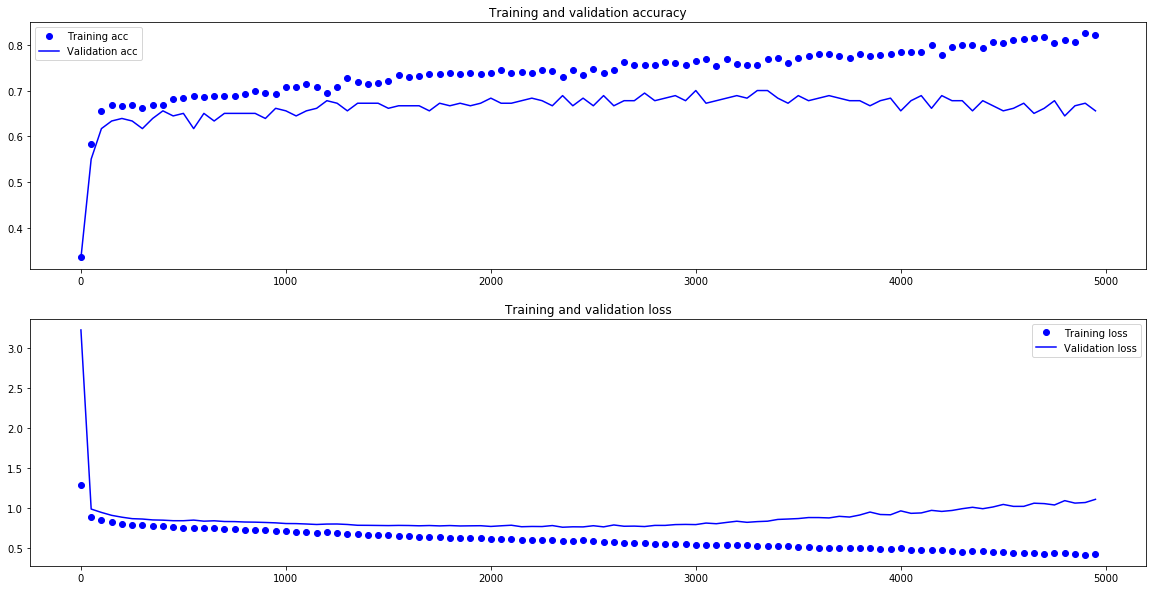

In [44]:
plot_history(history)

## There seems to be a large discrepancy between training and test loss
* up to 83% vs 66%
* number will vary as parameters are initialized randomly
* it seems if we trained for even longer it will still grow

## Objective: make the best prediction for unknown samples. 
* this is called generalization
* if we perform well on knwon data, but less good on unknown data this is called overfitting
* overfitting is to be avoided
* measures taken to avoid overfitting are also known as _regularization_.

### Let's plot the decision boundaries to get a better idea of what is going on
### First for training data

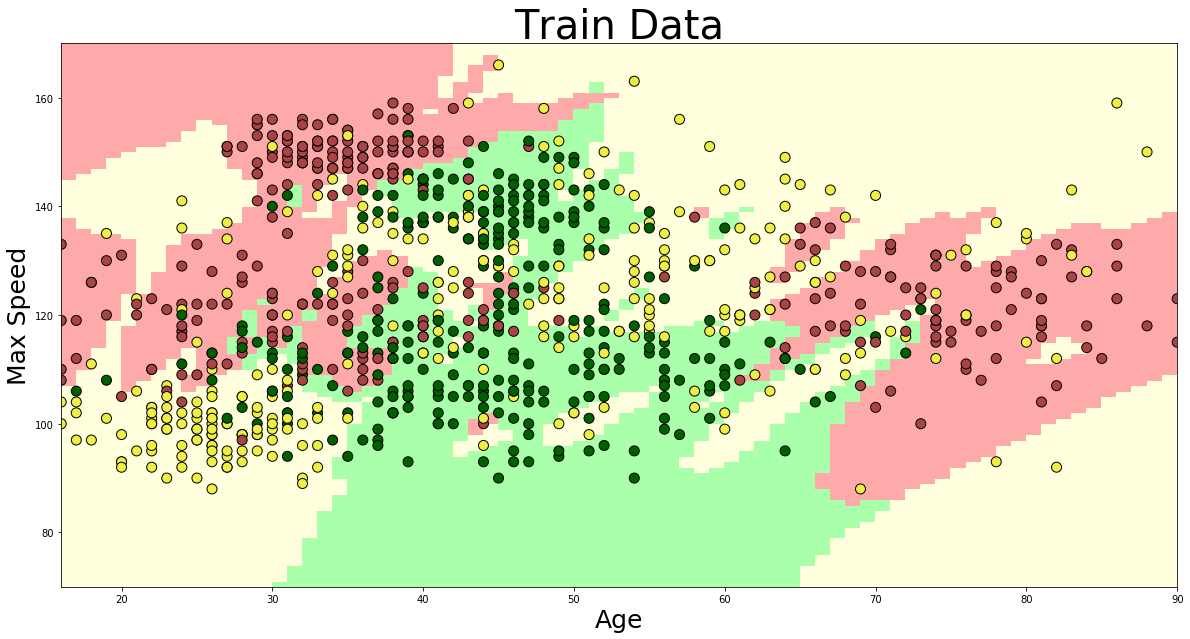

In [45]:
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data")

### Then for training data

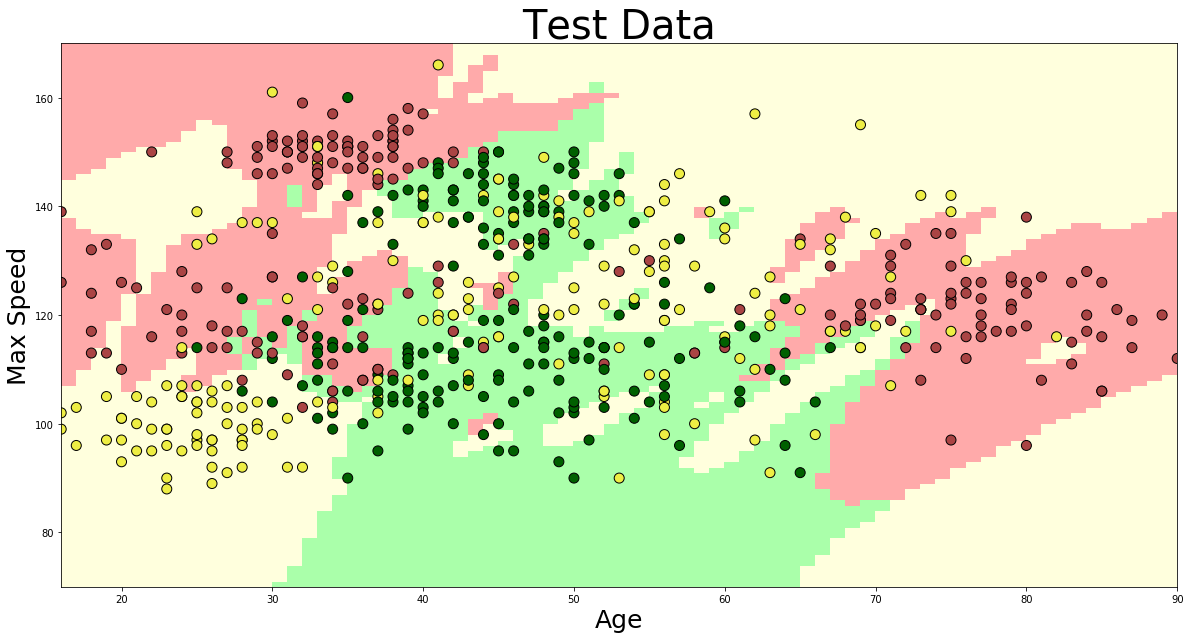

In [46]:
plot_prediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data")

### A rule of thumb: Smoother decision boundaries imply less overfitting
This matches our observation: we detect overfitting and the decision boundaries also look rather wild, especially on the upper left side of the plot